# Recurrent neural networks
Import various modules that we need for this notebook (now using Keras 1.0.0)

In [1]:
%pylab inline

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import re

from keras.datasets import imdb, reuters
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer

Populating the interactive namespace from numpy and matplotlib


Using Theano backend.


Load the MNIST dataset, flatten the images, convert the class labels, and scale the data.

### I. Load IMDB
Load the full IMBD dataset, from raw text. The first step is to load each text snippet into a python list.

In [2]:
path = "../../../class_data/aclImdb/"

ff = [path + "train/pos/" + x for x in os.listdir(path + "train/pos")] + \
     [path + "train/neg/" + x for x in os.listdir(path + "train/neg")] + \
     [path + "test/pos/" + x for x in os.listdir(path + "test/pos")] + \
     [path + "test/neg/" + x for x in os.listdir(path + "test/neg")]

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    
input_label = ([1] * 12500 + [0] * 12500) * 2
input_text  = []

for f in ff:
    with open(f) as fin:
        pass
        input_text += [remove_tags(" ".join(fin.readlines()))]

Next, we construct a tokenizer object, initialized with the number of total terms we want. I then use the training data to find the top most used words.

In [3]:
num_words = 2000
tok = Tokenizer(num_words)
tok.fit_on_texts(input_text[:25000])

The tokenizer makes getting the words themeselves out oddly difficult, but this will do it for us:

In [4]:
words = []
for iter in range(num_words):
    words += [key for key,value in tok.word_index.items() if value==iter+1]

words[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this']

We can now use the tokenizer to construct data matricies that look like the ones pre-supplied by keras.

In [5]:
X_train = tok.texts_to_sequences(input_text[:25000])
X_test  = tok.texts_to_sequences(input_text[25000:])
y_train = input_label[:25000]
y_test  = input_label[25000:]

X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test  = sequence.pad_sequences(X_test,  maxlen=100)

To reconstruct the text, which will have any words not in our vocabulary removed, we can use this function:

In [6]:
def reconstruct_text(index, words):
    text = []
    for ind in index:
        if ind != 0:
            text += [words[ind-1]]
        else:
            text += [""]
    return text

print(input_text[100])
print("\n\n")
print(reconstruct_text(X_train[100][:40], words))

I was prepared for a turgid talky soap opera cum travelogue, but was pleased to find a fast-paced script, an underlying moral, excellent portrayals from all the actors, especially Peter Finch, amazing special effects, suspense, and beautiful cinematography--there's even a shot of the majestic stone Buddhas recently destroyed by the Taliban. Not to mention Elizabeth Taylor at her most gloriously beautiful and sympathetic, before she gave in to the gaspy hysterics that marred her later work. All the supporting players round it out, and I do wonder who trained all those elephants.Speaking of the stone-Buddha sequence, you really can discern that it's Vivien Leigh in the long shots. Her shape and the way she moves is distinct from Taylor's. The only thing marring that sequence are the poorly done process shots, where the background moves by much too fast for horses at a walk.If you want a thought-provoking film that is beautiful to watch and never boring, spend a few hours with Elephant Wa

Notice that much of the original context is gone given our aggressive filtering, but the main tone (in this case, at least) remains. We would probably want to filter out a few things, like numbers, if we were being more careful.

### II. Basic RNN example
Using this new dataset, let's build a plain, vanilliar RNN.

In [8]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

I think it is incredibly important to make sure the shape of the weights and bias make sense to you. If they do, you probably understand a large part of what is going on.

In [9]:
print(model.layers[2].get_weights()[0].shape) # W - input weights
print(model.layers[2].get_weights()[1].shape) # U - recurrent weights
print(model.layers[2].get_weights()[2].shape) # b - bias

(32, 16)
(16, 16)
(16,)


Fitting the model works exactly the same as with CNNs or dense neural networks.

In [10]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=10, verbose=1,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 13s - loss: 0.5246 - acc: 0.7090 - val_loss: 0.4072 - val_acc: 0.8142
Epoch 2/10
25000/25000 [==============================] - 11s - loss: 0.3758 - acc: 0.8423 - val_loss: 0.4585 - val_acc: 0.8117
Epoch 3/10
25000/25000 [==============================] - 11s - loss: 0.3512 - acc: 0.8514 - val_loss: 0.3670 - val_acc: 0.8396
Epoch 4/10
25000/25000 [==============================] - 11s - loss: 0.3379 - acc: 0.8578 - val_loss: 0.4272 - val_acc: 0.8094
Epoch 5/10
25000/25000 [==============================] - 11s - loss: 0.3306 - acc: 0.8641 - val_loss: 0.3857 - val_acc: 0.8396
Epoch 6/10
25000/25000 [==============================] - 11s - loss: 0.3189 - acc: 0.8680 - val_loss: 0.3596 - val_acc: 0.8417
Epoch 7/10
25000/25000 [==============================] - 11s - loss: 0.3116 - acc: 0.8710 - val_loss: 0.4935 - val_acc: 0.8243
Epoch 8/10
25000/25000 [==============================

### III. LSTM
We can replicate this RNN, but substitute out the SimpleRNN with LSTM. In Keras, this is made (almost too) easy; we just plug in a different layer type.

In [11]:
model = Sequential()

model.add(Embedding(num_words, 50))
model.add(Dropout(0.25))

model.add(LSTM(32))

model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

The weights in the LSTM layer are quite a bit more complex, with four triples of W, U, and b. All three have the same dimension, however.

In [12]:
print(model.layers[2].get_weights()[0].shape)  # W_i  input gate weights
print(model.layers[2].get_weights()[1].shape)  # U_i
print(model.layers[2].get_weights()[2].shape)  # b_i
print(model.layers[2].get_weights()[3].shape)  # W_f  forget weights
print(model.layers[2].get_weights()[4].shape)  # U_f
print(model.layers[2].get_weights()[5].shape)  # b_f
print(model.layers[2].get_weights()[6].shape)  # W_c  cell weights
print(model.layers[2].get_weights()[7].shape)  # U_c
print(model.layers[2].get_weights()[8].shape)  # b_c
print(model.layers[2].get_weights()[9].shape)  # W_o  output weights
print(model.layers[2].get_weights()[10].shape) # U_o
print(model.layers[2].get_weights()[11].shape) # b_o

(50, 32)
(32, 32)
(32,)
(50, 32)
(32, 32)
(32,)
(50, 32)
(32, 32)
(32,)
(50, 32)
(32, 32)
(32,)


We'll train the model the same as with the SimpleRNN, but the computational time will be significantly higher. The algorithm needs to backpropagate the complex mechanism inside of the LSTM unit through the entire time series, so this does not seem too surprising.

In [13]:
model.fit(X_train, y_train, batch_size=1, nb_epoch=10, verbose=1,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 325s - loss: 0.5212 - acc: 0.7779 - val_loss: 0.4049 - val_acc: 0.8421
Epoch 2/10
25000/25000 [==============================] - 377s - loss: 0.4660 - acc: 0.8341 - val_loss: 0.3863 - val_acc: 0.8501
Epoch 3/10
25000/25000 [==============================] - 377s - loss: 0.4570 - acc: 0.8498 - val_loss: 0.5080 - val_acc: 0.8345
Epoch 4/10
25000/25000 [==============================] - 381s - loss: 0.4665 - acc: 0.8574 - val_loss: 0.4065 - val_acc: 0.8575
Epoch 5/10
25000/25000 [==============================] - 373s - loss: 0.4596 - acc: 0.8658 - val_loss: 0.4526 - val_acc: 0.8402
Epoch 6/10
25000/25000 [==============================] - 325s - loss: 0.4533 - acc: 0.8688 - val_loss: 0.4846 - val_acc: 0.8438
Epoch 7/10
25000/25000 [==============================] - 325s - loss: 0.4578 - acc: 0.8733 - val_loss: 0.5307 - val_acc: 0.8216
Epoch 8/10
25000/25000 [=======================

### IV. GRU
And, similarly, here is a GRU layer. Again, from the perspective of using it in Keras, it only requires a minor change to the code.

In [14]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(GRU(32,activation='relu'))

model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

GRU's have one fewer sets of weights (W,U,b).

In [15]:
print(model.layers[2].get_weights()[0].shape) # W_z  update weights
print(model.layers[2].get_weights()[1].shape) # U_z
print(model.layers[2].get_weights()[2].shape) # b_z
print(model.layers[2].get_weights()[3].shape) # W_r  reset weights
print(model.layers[2].get_weights()[4].shape) # U_r
print(model.layers[2].get_weights()[5].shape) # b_r
print(model.layers[2].get_weights()[6].shape) # W_h  output weights
print(model.layers[2].get_weights()[7].shape) # U_h
print(model.layers[2].get_weights()[8].shape) # b_h

(32, 32)
(32, 32)
(32,)
(32, 32)
(32, 32)
(32,)
(32, 32)
(32, 32)
(32,)


In [16]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=20, verbose=1,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 30s - loss: 0.5714 - acc: 0.6774 - val_loss: 0.4126 - val_acc: 0.8121
Epoch 2/20
25000/25000 [==============================] - 32s - loss: 0.3749 - acc: 0.8356 - val_loss: 0.3310 - val_acc: 0.8546
Epoch 3/20
25000/25000 [==============================] - 32s - loss: 0.3342 - acc: 0.8576 - val_loss: 0.3875 - val_acc: 0.8311
Epoch 4/20
25000/25000 [==============================] - 31s - loss: 0.3147 - acc: 0.8688 - val_loss: 0.3617 - val_acc: 0.8408
Epoch 5/20
25000/25000 [==============================] - 31s - loss: 0.3062 - acc: 0.8734 - val_loss: 0.3263 - val_acc: 0.8575
Epoch 6/20
25000/25000 [==============================] - 31s - loss: 0.2935 - acc: 0.8782 - val_loss: 0.4979 - val_acc: 0.8072
Epoch 7/20
25000/25000 [==============================] - 31s - loss: 0.2803 - acc: 0.8866 - val_loss: 0.3317 - val_acc: 0.8594
Epoch 8/20
25000/25000 [==============================

### V. Evaluating a sequence of inputs
Now, RNNs can be made to actually output results after every cycle. When the upper levels are trained on just the final one, these can be turned on to track the output of the model through the sequence of text.

In [17]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=1,
          validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 13s - loss: 0.6271 - acc: 0.6123 - val_loss: 0.4382 - val_acc: 0.8032
Epoch 2/5
25000/25000 [==============================] - 13s - loss: 0.4094 - acc: 0.8184 - val_loss: 0.4593 - val_acc: 0.7848
Epoch 3/5
25000/25000 [==============================] - 12s - loss: 0.3614 - acc: 0.8454 - val_loss: 0.4181 - val_acc: 0.8274
Epoch 4/5
25000/25000 [==============================] - 13s - loss: 0.3410 - acc: 0.8555 - val_loss: 0.3922 - val_acc: 0.8259
Epoch 5/5
25000/25000 [==============================] - 13s - loss: 0.3214 - acc: 0.8650 - val_loss: 0.4428 - val_acc: 0.8097


Now that we've trained on the final output, we want to take the same weights as before, but to make SimpleRNN return the entire sequence. The output layer will then return a result of size 100, rather than size 1; this is the result of the algorithm after seeing just the first k terms. The last value will be the same as using `model`. 

To do this, as far as I can tell, one needs to create a new model from scratch and then load the weights from the old model. We have to wrap any layers with learnable weights above the SimpleRNN in the wrapper `TimeDistributed`, so that it knows to apply the weights seperately to the time-components from the prior level.

In [19]:
model2 = Sequential()

model2.add(Embedding(num_words, 32, input_length=100))
model2.add(Dropout(0.25))

model2.add(SimpleRNN(16, return_sequences=True))

model2.add(TimeDistributed(Dense(256)))
model2.add(Dropout(0.25))
model2.add(Activation('relu'))

model2.add(TimeDistributed(Dense(1)))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [20]:
model2.set_weights(model.get_weights())

Notice that the dimensions of the weights are exactly the same; the input sizes are larger, but with weight sharing we can use the same weight matricies. This is akin to the OverFeat paper for CNNs where a convolution is applied to a larger image; the output's dimensions just increase.

Let's now predict the sequence of values for the entire training set.

In [21]:
y_hat2 = model2.predict(X_train)
y_hat2.shape

(25000, 100, 1)

### VI. Visualize the output
Here is a nice visualization of the progress of the algorithm for various input texts.

I was prepared for a turgid talky soap opera cum travelogue, but was pleased to find a fast-paced script, an underlying moral, excellent portrayals from all the actors, especially Peter Finch, amazing special effects, suspense, and beautiful cinematography--there's even a shot of the majestic stone Buddhas recently destroyed by the Taliban. Not to mention Elizabeth Taylor at her most gloriously beautiful and sympathetic, before she gave in to the gaspy hysterics that marred her later work. All the supporting players round it out, and I do wonder who trained all those elephants.Speaking of the stone-Buddha sequence, you really can discern that it's Vivien Leigh in the long shots. Her shape and the way she moves is distinct from Taylor's. The only thing marring that sequence are the poorly done process shots, where the background moves by much too fast for horses at a walk.If you want a thought-provoking film that is beautiful to watch and never boring, spend a few hours with Elephant Wa

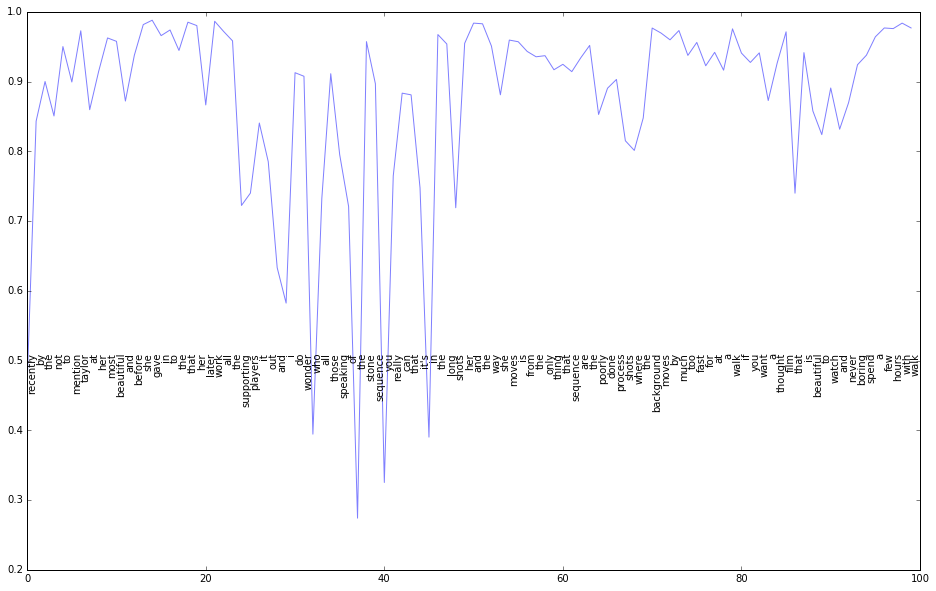

In [22]:
ind = 100
tokens = reconstruct_text(X_train[ind], words)

print(input_text[ind])

plt.figure(figsize=(16, 10))
plt.plot(y_hat2[iter],alpha=0.5)
for i in range(len(tokens)):
    plt.text(i,0.5,tokens[i],rotation=90)

This film is about a group of five friends who rent a cabin in the woods. One of the friends catches a horrifying flesh-eating virus. Suddenly, the friends turn on one another in a desperate attempt to keep from contracting the disease themselves."Cabin Fever" is a horrible film. For one, it tries to be many genres at once. Is it supposed to be a homage, a slasher, a black comedy, or a scary movie with unintentional comedy? Nobody can tell. There's a serious scene at first and a second alter, it turns funny. When the film tries to be funny, the humor is quite bland, excluding the ending. I liked the ending a lot.But apart from the ending, I was pretty disappointed and disgusted. The violence is cringe-worthy, more looking away from the screen than being scared. The tone changes within each scene, sometimes funny, sometimes scary, and sometimes quite random. In fact, you see a girl doing karate in slo-motion. What are we supposed to get from that? This same girl would bite one of the ch

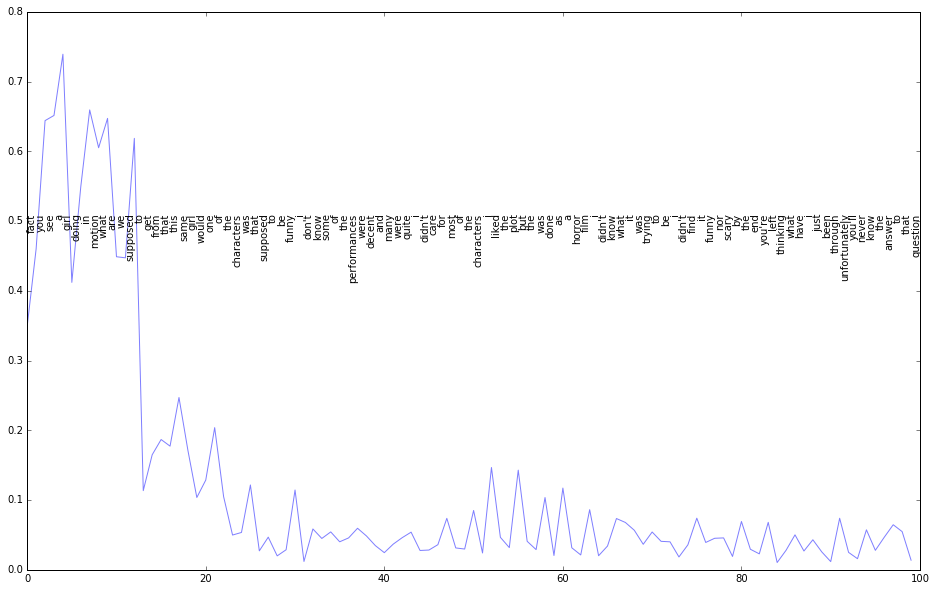

In [23]:
ind = 22000
tokens = reconstruct_text(X_train[ind], words)

print(input_text[ind])

plt.figure(figsize=(16, 10))
plt.plot(y_hat2[ind],alpha=0.5)
for i in range(len(tokens)):
    plt.text(i,0.5,tokens[i],rotation=90)

I really liked Tom Barman's AWTWB. You just have to let it come over you and enjoy it while it lasts, and don't expect anything. It's like sitting on a café-terrace with a beer, in the summer sun, and watching the people go by. It definitely won't keep you pondering afterwards, that's true, but that's not a prerequisite for a good film. It's just the experience during the movie that's great.I felt there were a few strands that could have been worked out a little more, but being a Lynch fan I don't care that much anymore :)And I *loved* the style, or flair of this movie. It's slick, but fresh, and the soundtrack is a beauty. Any music-lover will get his kicks out of AWTWB, I can assure you.I'll give it 8 out 10.(music-wise 10 out of 10)


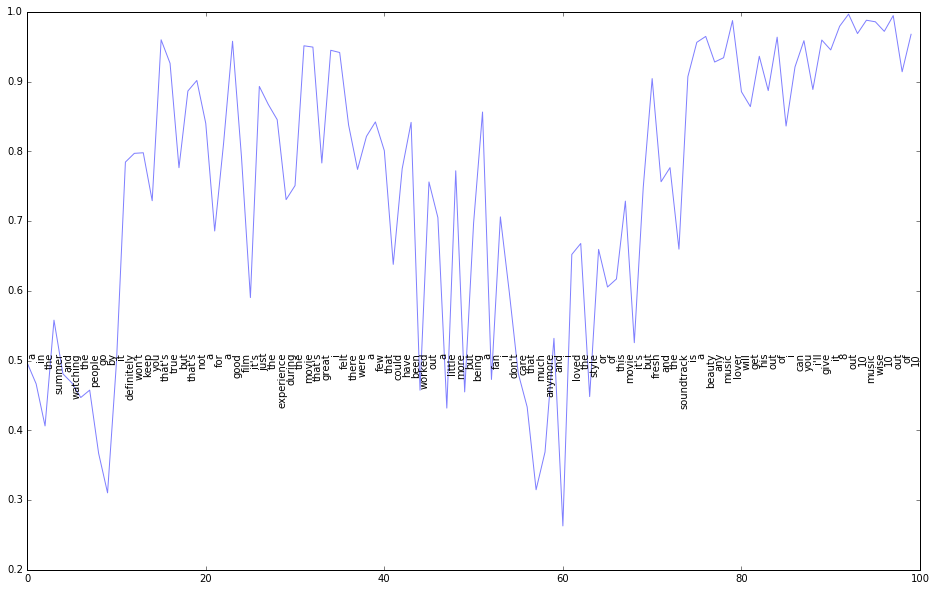

In [24]:
ind = 10000
tokens = reconstruct_text(X_train[ind], words)

print(input_text[ind])

plt.figure(figsize=(16, 10))
plt.plot(y_hat2[ind],alpha=0.5)
for i in range(len(tokens)):
    plt.text(i,0.5,tokens[i],rotation=90)